# Image Representation

Using the `ImageFeatures` package to determine features or descriptors of an image. Later, will be used for object recognition, detection, matching, or overlaying.

## Using features and descriptors

To find areas that match between images, find commonalities. For cats, this might be ears and eyes.

### FAST Corner Detection

_Corner Detection_ is extracting intersection features from images. `ImageFeatures` implements "Features from Accelerated Segment Test" or FAST, as `fastcorners`. FAST scans for object corners, uses a circle of 16 pixels to evaluate if a point is a corner. Configured by 2 parameters

- Number of contiguous pixels (N)
- Threshold Value

Looking at applying this to cat images

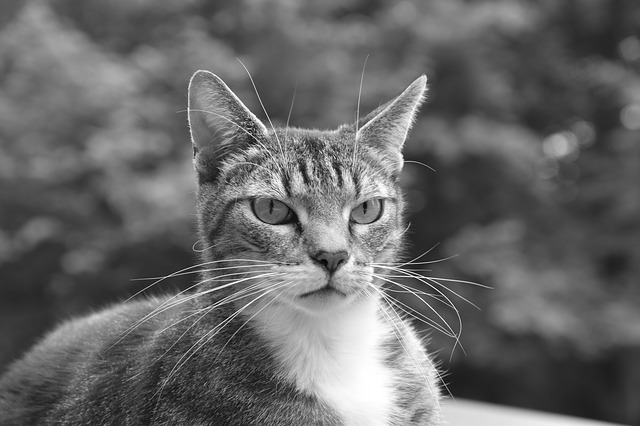

In [1]:
using Images, ImageFeatures
img = Gray.(load("../sample-images/cat-3417184_640.jpg"))

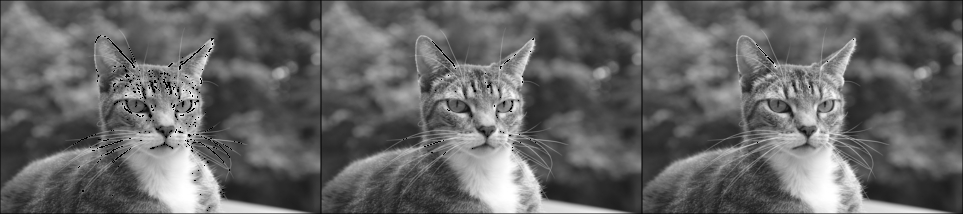

In [2]:
img_f = Float16.(restrict(img))
new_img = Gray.(hcat(
 img_f .* (.~fastcorners(img_f, 12, 0.15)),
 img_f .* (.~fastcorners(img_f, 12, 0.25)),
 img_f .* (.~fastcorners(img_f, 12, 0.35))
))

Here, the black dots represent corners identified by FAST. This can help identify areas that have content, for example in a newspaper example. Unfortunately, the newspaper image isn't in the Git repository.

### `imcorner` Function for Corner Detection

`imcorner` is an alternative to `fastcorners`, has a different set of methods

- `harris`
- `shi-tomasi`
- `kitchen-rosenfield`

Using a chessboard example,

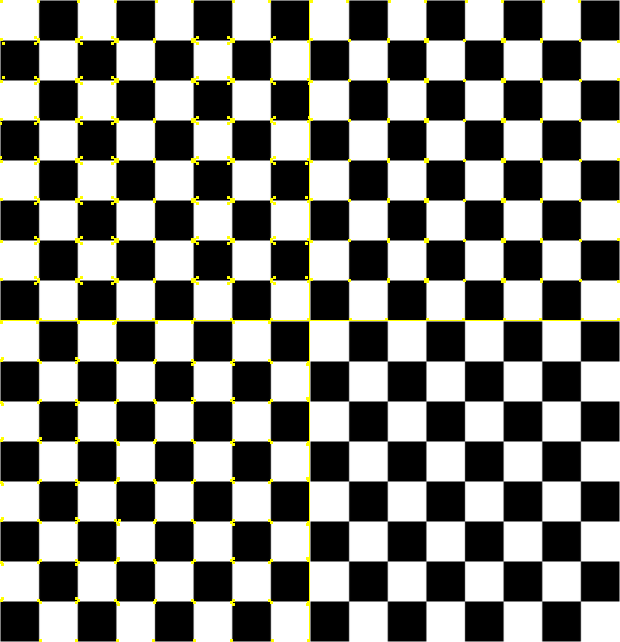

In [3]:
using ImageMorphology, ImageView

img = restrict(load("../sample-images/board-157165_640.png"))
img_f = Float16.(Gray.(img))

img_harris = copy(img)
img_harris[dilate(imcorner(img_f, method=harris)) .> 0.01] .= colorant"yellow"

img_shi = copy(img)
img_shi[dilate(imcorner(img_f, method=shi_tomasi)) .> 0.01] .= colorant"yellow"

img_rosenfield = copy(img)
img_rosenfield[dilate(imcorner(img_f, method=kitchen_rosenfeld)) .> 0.01] .= colorant"yellow"

img_fast = copy(img)
img_fast[dilate(fastcorners(img_f, 12, 0.05)) .> 0.01] .= colorant"yellow"


new_img = vcat(
 hcat(img_harris, img_shi),
 hcat(img_rosenfield, img_fast)
)


new_img[Int(size(new_img, 1) / 2), :] .= colorant"yellow"
new_img[:, Int(size(new_img, 2) / 2)] .= colorant"yellow"

new_img

The top left corner is `harris`,which identifies many different corners compared to FAST on the bottom right, which doesn't identify any corners. Next, seeing both on a cat image

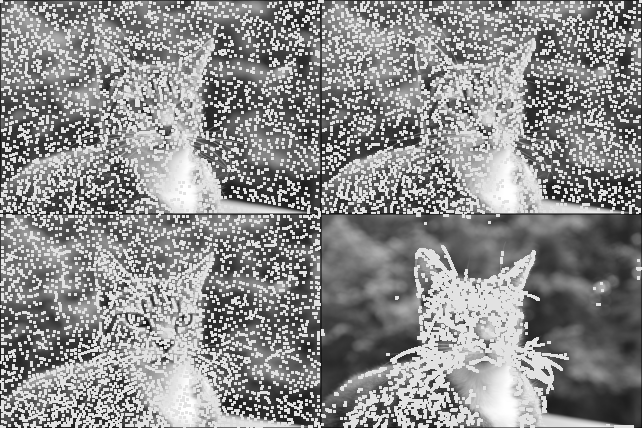

In [5]:
img = Gray.(restrict(load("../sample-images/cat-3417184_640.jpg")))
img_f = Float16.(Gray.(img))

img_harris = copy(img)
img_harris[dilate(imcorner(img_f, method=harris)) .> 0.01] .= colorant"yellow"

img_shi = copy(img)
img_shi[dilate(imcorner(img_f, method=shi_tomasi)) .> 0.01] .= colorant"yellow"

img_rosenfield = copy(img)
img_rosenfield[dilate(imcorner(img_f, method=kitchen_rosenfeld)) .> 0.01] .= colorant"yellow"

img_fast = copy(img)
img_fast[dilate(fastcorners(img_f, 12, 0.05)) .> 0.01] .= colorant"yellow"

new_img = vcat(
 hcat(img_harris, img_shi),
 hcat(img_rosenfield,img_fast)
)

new_img

All methods appear to have spurious random corners, other than FAST, which appears to work reasonably well. This threshold is set at pretty low, so let's try raising it to 95% so we retain just the top 5% of features.

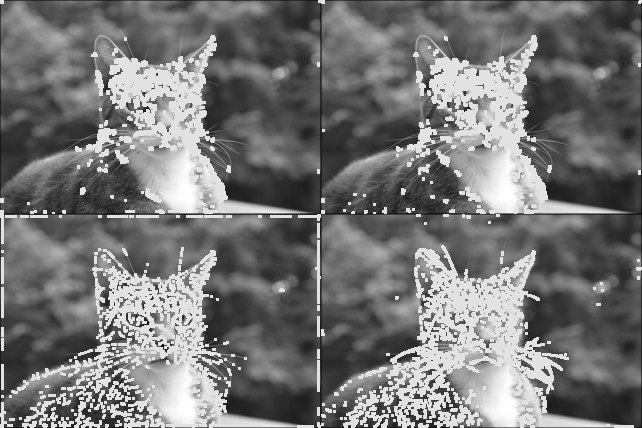

In [10]:
img = Gray.(restrict(load("../sample-images/cat-3417184_640.jpg")))
img_f = Float16.(Gray.(img))

img_harris = copy(img)
img_harris[dilate(imcorner(img_f, Percentile(95), method=harris)) .> 0.01] .= colorant"yellow"

img_shi = copy(img)
img_shi[dilate(imcorner(img_f, Percentile(95), method=shi_tomasi)) .> 0.01] .= colorant"yellow"

img_rosenfield = copy(img)
img_rosenfield[dilate(imcorner(img_f, Percentile(95), method=kitchen_rosenfeld)) .> 0.01] .= colorant"yellow"

img_fast = copy(img)
img_fast[dilate(fastcorners(img_f, 12, 0.05)) .> 0.01] .= colorant"yellow"

new_img = vcat(
 hcat(img_harris, img_shi),
 hcat(img_rosenfield, img_fast)
)
new_img

Okay, so this is better and more consistent, so that's good.

### Benchmarking

With comparable results, it's useful to consider performance between algorithms

In [14]:
@btime fastcorners(img_f, 12, 0.15);

  4.164 ms (7 allocations: 150.02 KiB)


In [15]:
@btime fastcorners(img_f, 12, 0.05);

  5.826 ms (7 allocations: 150.02 KiB)


In [16]:
@btime imcorner(img_f, method=harris);

  11.039 ms (13609 allocations: 8.13 MiB)


In [17]:
@btime imcorner(img_f, Percentile(95), method=harris);

  8.367 ms (427 allocations: 8.09 MiB)


In [18]:
@btime imcorner(img_f, method=shi_tomasi);

  10.289 ms (14802 allocations: 8.17 MiB)


In [19]:
@btime imcorner(img_f, method=kitchen_rosenfeld);

  10.458 ms (16396 allocations: 7.72 MiB)


One takeaway is that the smaller threshold for `fastcorners` doesn't affect performance. This is preferable, we'll be using it extensively for this reason.

### Binary Robust Independent Elementary Features (BRIEF)

BRIEF is a binary feature point descriptor. It's efficient and simple, unfortunately it can't be applied to scaled or rotated images. However, it can be used for tasks like duplicate detection.

An example we'll look at is a watermarked version of the cat image, to see if we can determine if it's a duplicate image.

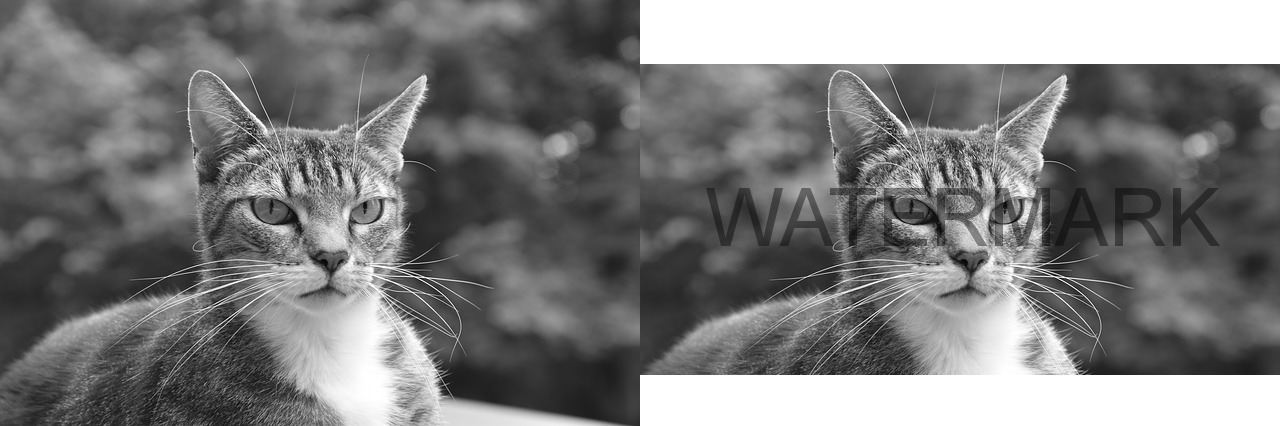

In [21]:
img1 = Gray.(load("../sample-images/cat-3417184_640.jpg"))
img2 = Gray.(load("../sample-images/cat-3417184_640_watermarked.jpg"))
mosaicview(img1, img2, ncol=2)

Next, use `fastcorners` to isolate keypoints (corners) and compare their counts. 

In [24]:
keypoints_1 = Keypoints(fastcorners(img1, 12, 0.5));
# 0.5 - very high threshold
keypoints_2 = Keypoints(fastcorners(img2, 12, 0.5));
println("Keypoints original: ", size(keypoints_1))
println("Keypoints watermark: ", size(keypoints_2))

Keypoints original: (199,)
Keypoints watermark: (200,)


These are extremely close. Next, we want to see how they match, using BRIEF's `create_descriptor` then matching keypoints with `match_keypoints`.

In [26]:
brief_params = BRIEF()
desc_1, ret_features_1 = create_descriptor(img1, keypoints_1, brief_params);
desc_2, ret_features_2 = create_descriptor(img2, keypoints_2, brief_params);
matches = match_keypoints(ret_features_1, ret_features_2, desc_1, desc_2, 0.5);

The "matches" are the number of matches between features. Size shows us the count.

In [27]:
size(matches)

(199,)

Most are matches. Next to compare, we'll merge images and draw a line to indicate the matches.

┌ Info: Precompiling ImageDraw [4381153b-2b60-58ae-a1ba-fd683676385f]
└ @ Base loading.jl:1278


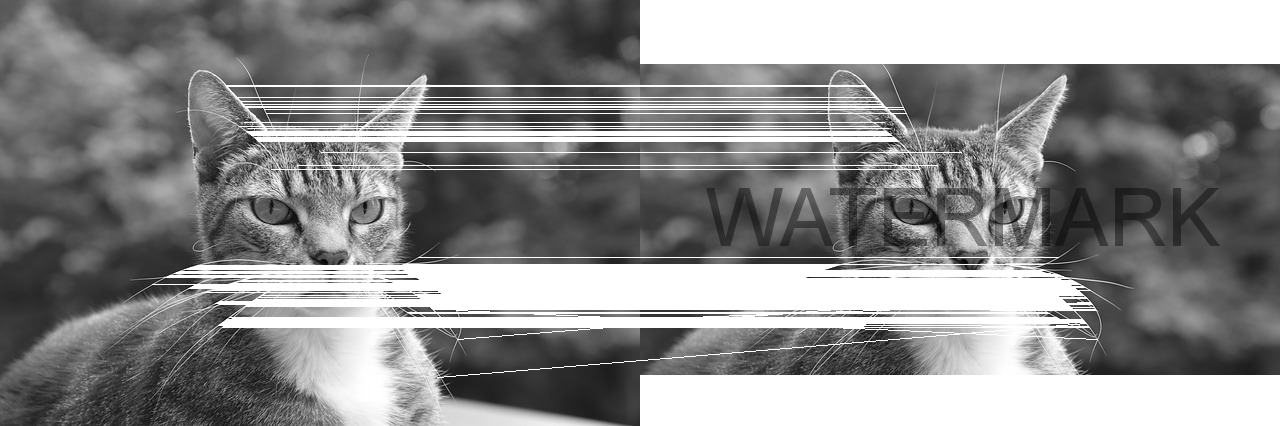

In [32]:
using ImageDraw
grid = hcat(img1, img2)
offset = CartesianIndex(0, size(img1, 2))
map(m -> draw!(grid, LineSegment(m[1], m[2] + offset)), matches)
grid